/home/s1803229/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


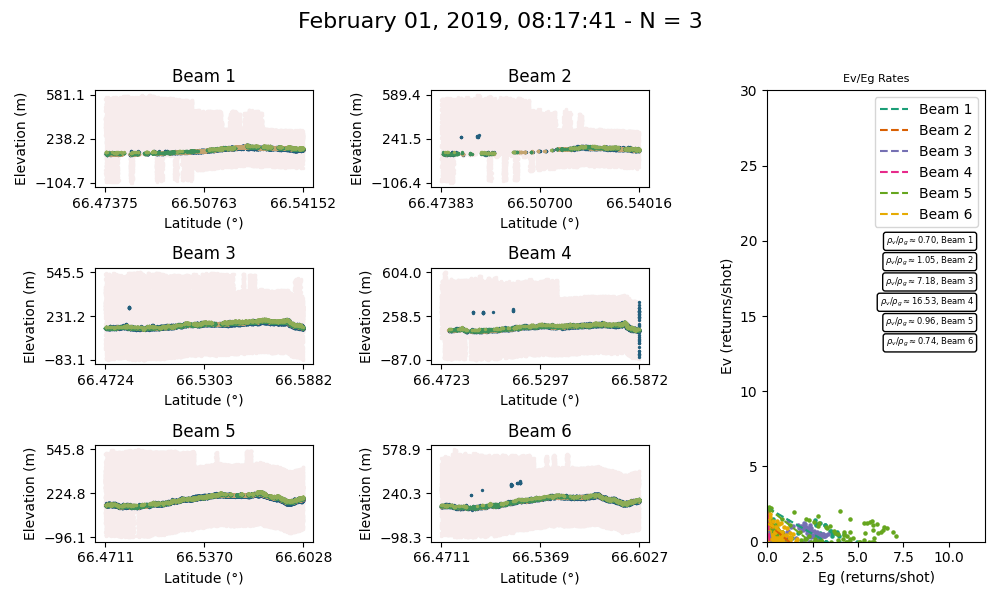

In [1]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, cmap2, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scripts.pvpg_fixed import *
from scripts.track_pairs import *
from scripts.show_tracks import *

%matplotlib ipympl

dirpath = '../data/rovaniemi_w/'
all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

for j in range(3,4):
    pvpg_concise(all_ATL03[j],all_ATL08[j],
                           f_scale=.1,
                           loss = 'arctan',
                           file_index=j,
                           zeros = True)

[-0.6975411   2.16417909  1.3203125   1.39855075  1.5182482   2.27857137
  1.86666667]


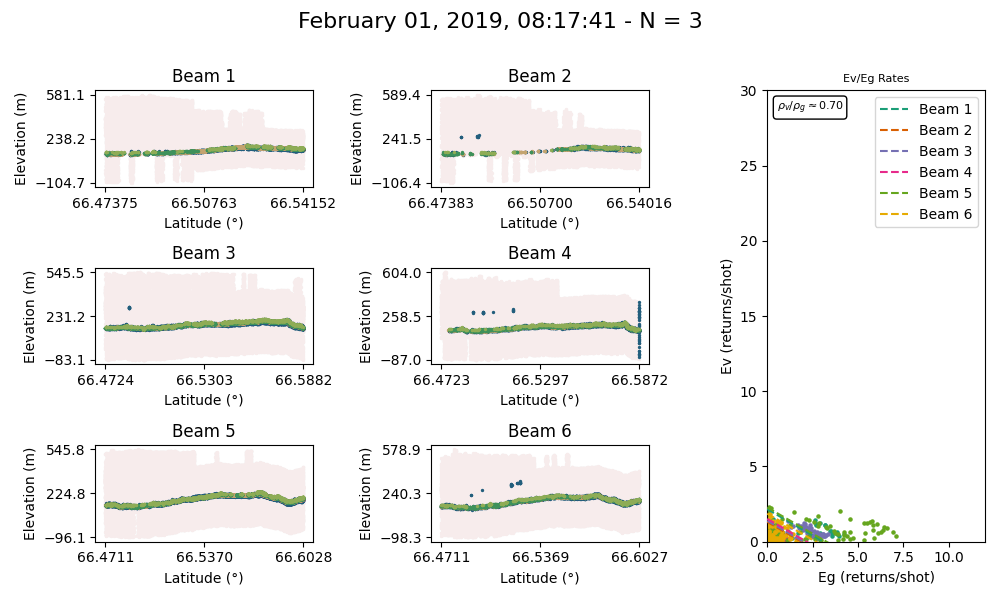

In [28]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, cmap2, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scripts.pvpg_fixed import *
from scripts.track_pairs import *
from scripts.show_tracks import *
from scripts.parallel import pvpg_parallel_method1

%matplotlib ipympl

dirpath = '../data/rovaniemi_w/'
all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

for j in range(3,4):
    pvpg_parallel_method1(all_ATL03[j],all_ATL08[j],
                           init = -.01,
                           # f_scale=.01,
                           loss = 'linear',
                           file_index=j,
                           zeros = False)

[-1.06672605e+00  1.20407740e+00  6.49034899e-02  1.91681402e+00
  2.93726257e-48  3.46422422e+00  3.67276805e-02]


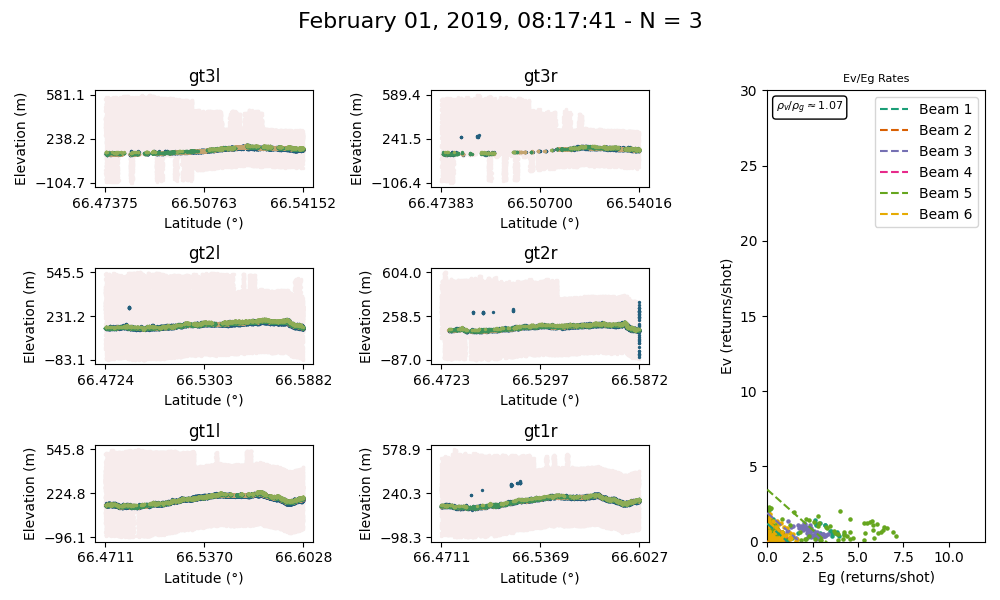

In [2]:
from scripts.imports import os, glob, pdb, np, h5py, pd, xr, gpd, Proj, Transformer, CRS, \
                        plt, cmap, cmap2, Model, Data, ODR, datetime, rasterio, show, \
                        ccrs, cfeature
from scripts.classes_fixed import *
from scripts.pvpg_fixed import *
from scripts.track_pairs import *
from scripts.show_tracks import *
from scripts.parallel import pvpg_parallel_method2

%matplotlib ipympl

dirpath = '../data/rovaniemi_w/'
all_ATL03, all_ATL08 = track_pairs(dirpath)
N = len(all_ATL03)

for j in range(3,4):
    pvpg_parallel_method2(all_ATL03[j],all_ATL08[j],
                           init = -1,
                           # f_scale=.2,
                           loss = 'arctan',
                           file_index=j,
                           zeros = False)